<a href="https://colab.research.google.com/github/trodrigue1304/Fraud_detection_algorithm/blob/master/source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Chargement des données et paramétrage de l'environnement de travail**

In [70]:
# Chargement des packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import sklearn as skl
import seaborn as sns
from google.colab import drive
from sklearn.impute import KNNImputer

# Connexion à google drive et importation des données
drive.mount('/content/drive')
id_train=pd.read_csv('/content/drive/My Drive/projet python/train_identity.csv')
tr_train=pd.read_csv('/content/drive/My Drive/projet python/train_transaction.csv')
id_test=pd.read_csv('/content/drive/My Drive/projet python/test_identity.csv')
tr_test=pd.read_csv('/content/drive/My Drive/projet python/test_transaction.csv')

## Affichage de toutes les lignes pour les outputs
pd.options.display.max_rows = 4000

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Première exploration des données**

**Visualisation des données**

In [71]:
id_train.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [72]:
tr_train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,0.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,mail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,87.0,19.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0,61.0,61.0,30.0,318.0,30.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,495.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
#verifier que toutes les TransactionID de id_train existe dans tr_train
print("Taille de la base identity : ",id_train.shape)
print("Taille de la base transaction : ",tr_train.shape)
print("Nombre de transactions uniques de la base transaction : ",id_train['TransactionID'].nunique())
print("Nombre de transactions uniques de la base identity : ",tr_train['TransactionID'].nunique())
print("Proportion de transactions avec id information (train): "+"{:.2%}".format(np.sum(tr_train['TransactionID'].isin(id_train['TransactionID'].unique()))/tr_train['TransactionID'].nunique()))
print("Proportion de transactions avec id information (test): "+"{:.2%}".format(np.sum(tr_test['TransactionID'].isin(id_test['TransactionID'].unique()))/tr_test['TransactionID'].nunique()))

Taille de la base identity :  (144233, 41)
Taille de la base transaction :  (590540, 394)
Nombre de transactions uniques de la base transaction :  144233
Nombre de transactions uniques de la base identity :  590540
Proportion de transactions avec id information (train): 24.42%
Proportion de transactions avec id information (test): 28.01%


On remarque qu'il y a des transactions sans informations d'identification. On ne tiendra pas compte de ces données.

**Fusion des bases de données**

In [74]:
train=pd.merge(tr_train,id_train,on="TransactionID",how="right")
test=pd.merge(tr_test,id_test,on="TransactionID",how="right")

**Type des variables**

In [75]:
train.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4                float64
D5                float64
D6                float64
D7                float64
D8          

**Détection des valeurs manquantes**

In [76]:
missing_data=train.isnull().sum().sum()
total_data=np.product(train.shape)
print("Proportion de données manquantes dans la base : "+"{:.2%}".format(missing_data/total_data))

Proportion de données manquantes dans la base : 26.89%


In [77]:
#Fonction pour la visualition de la répartition des données manquantes
def missing_view(data) :
  null_counts = data.isnull().sum()/len(data)
  plt.figure(figsize=(100,20))
  plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
  plt.ylabel('Proportion de données manquantes')
  plt.bar(np.arange(len(null_counts)),null_counts)


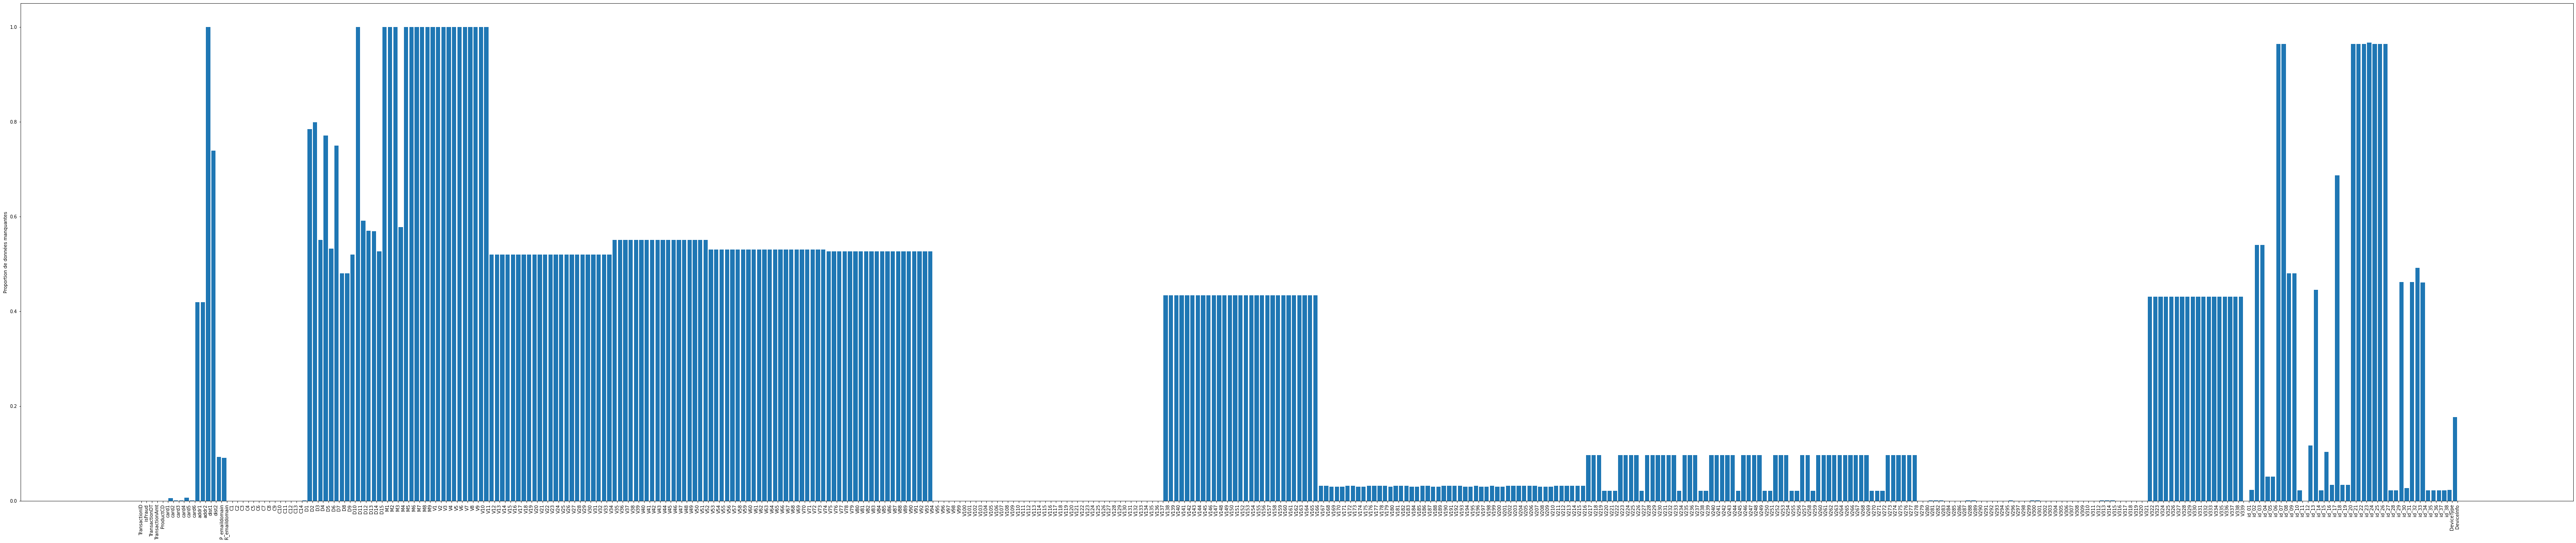

In [78]:
#Visualisation
missing_view(train)

Il faudra donc procéder à un traitement des valeurs manquantes et s'il le faut voir l'impact sur les modèles futurs.

**Analyse de la variable d'intérêt**

In [79]:
#Tableau des effectifs
tab = pd.DataFrame(train.groupby('isFraud').count()['TransactionID'])
tab

,TransactionID
isFraud,
0,132915
1,11318


Text(0.5, 1.0, 'Distribution de la variable isFraud')

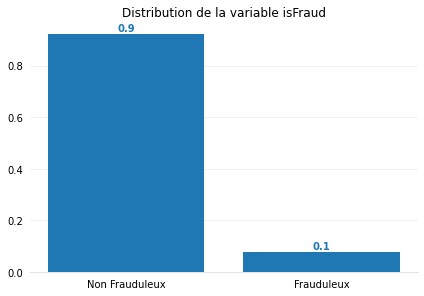

In [80]:
#Visualisation
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.01,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

fig.tight_layout()

ax.set_title("Distribution de la variable isFraud")

  On soupçonne un surapprentissage des modèles sur les valeurs non frauduleuses. On recalibre les données de manière à avoir une répartition uniforme.

In [81]:
#Recalibrage
class0=np.where(train['isFraud']==0)[0]
class1=np.where(train['isFraud']==1)[0]
class0_downsample=np.random.choice(class0,size=len(class1),replace=False)
Kept_index=sorted([*class0_downsample,*class1])
train_calibrate=train[train.index.isin(Kept_index)]

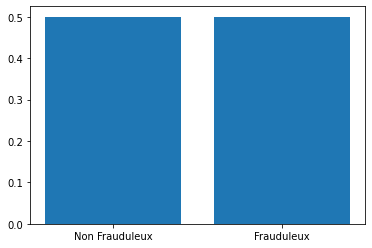

In [82]:
#On s'assure que le tirage a été bien fait
tab = pd.DataFrame(train_calibrate.groupby('isFraud').count()['TransactionID'])
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

**Visualisation des données manquantes dans la base recalibré**

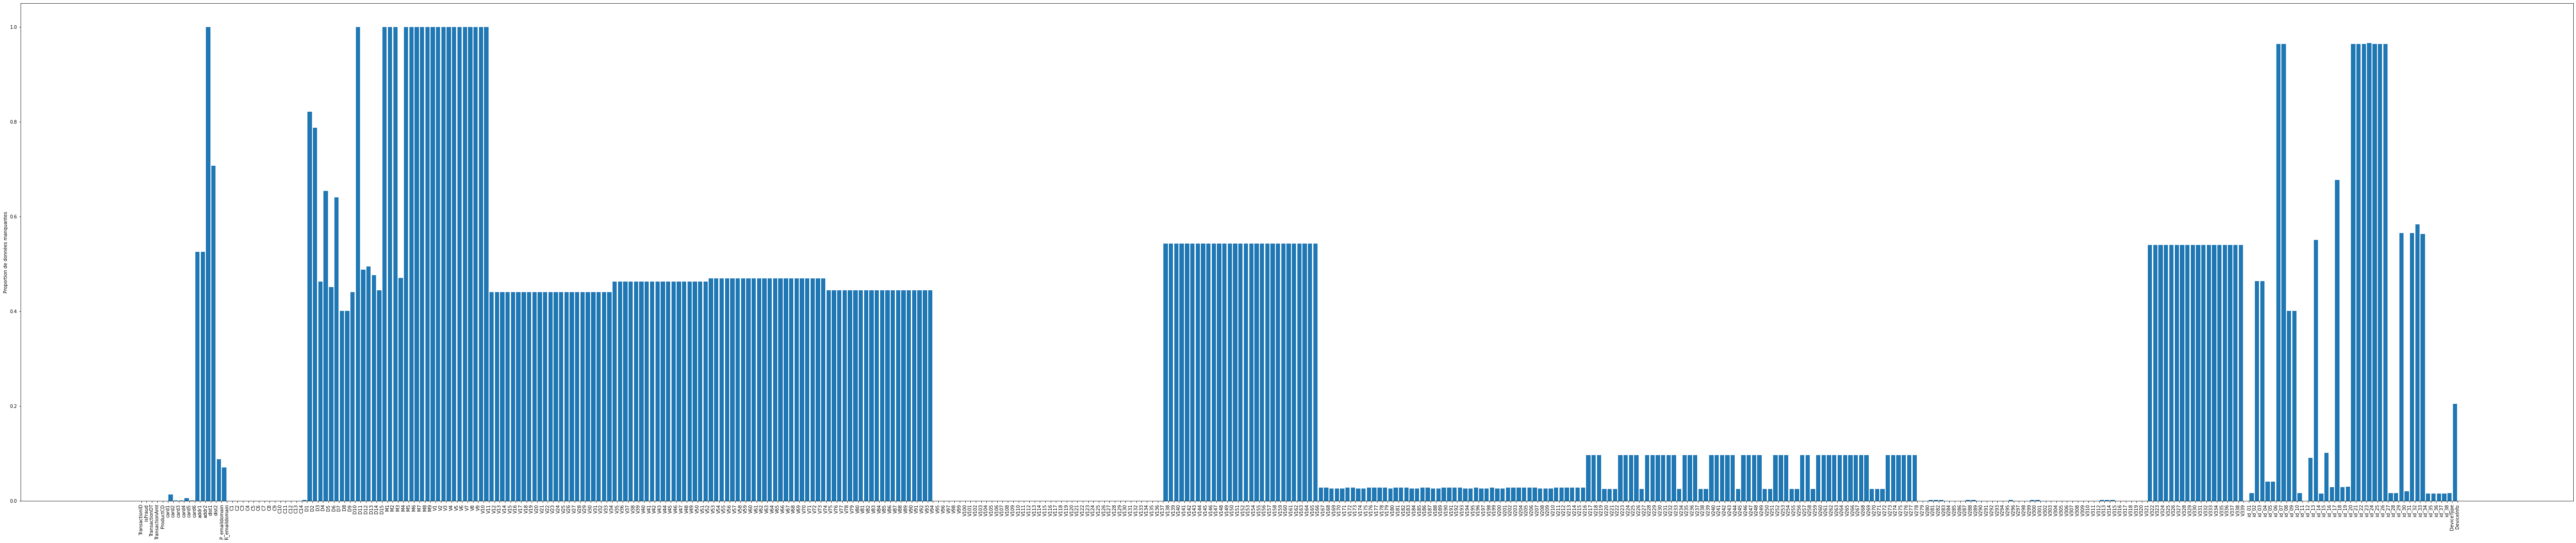

In [83]:
missing_view(train_calibrate)

On remarque que la distribution est quasiment la même avec celle obtenue avant. 
Conclusion : Les données recalibrées sont à l'image des données initiale sur ce plan. On peut donc se restreindre à la nouvelle base pour la suite des travaux.

### **Analyse et traitement des données manquantes**

**Valeurs manquantes suivant la variable d'intérêt**

Text(0.5, 0.98, 'Valeurs manquantes sur les données frauduleuses')

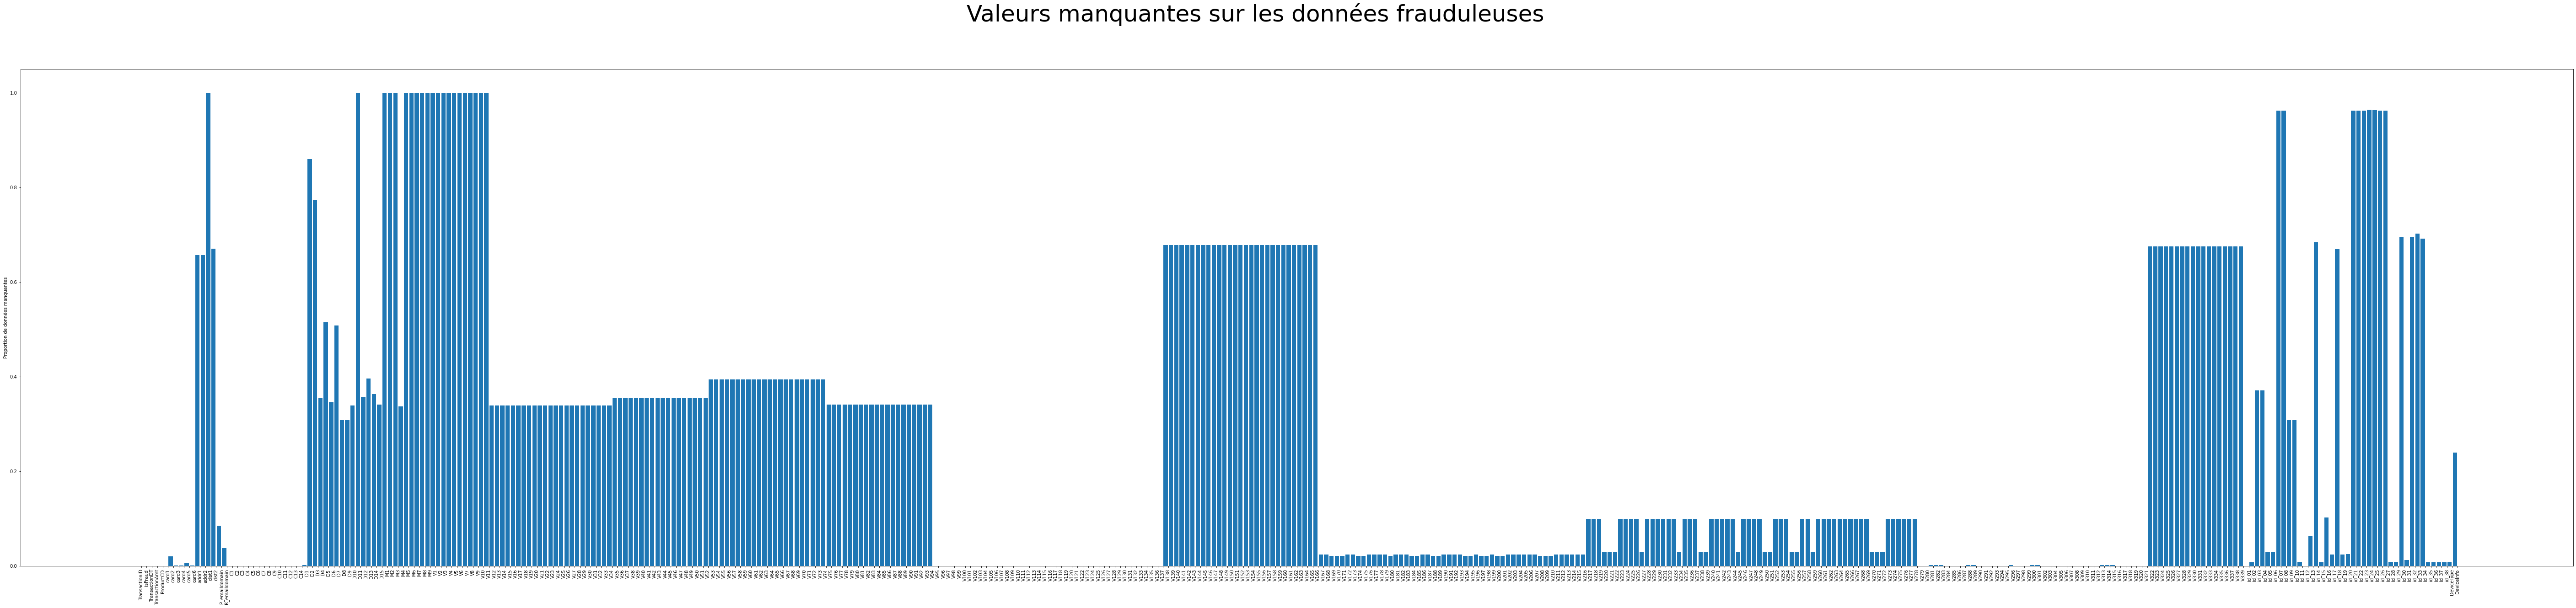

In [84]:
missing_view(train_calibrate[train_calibrate.isFraud == 1])
plt.suptitle("Valeurs manquantes sur les données frauduleuses", fontsize=50)

Text(0.5, 0.98, 'Valeurs manquantes sur les données non frauduleuses')

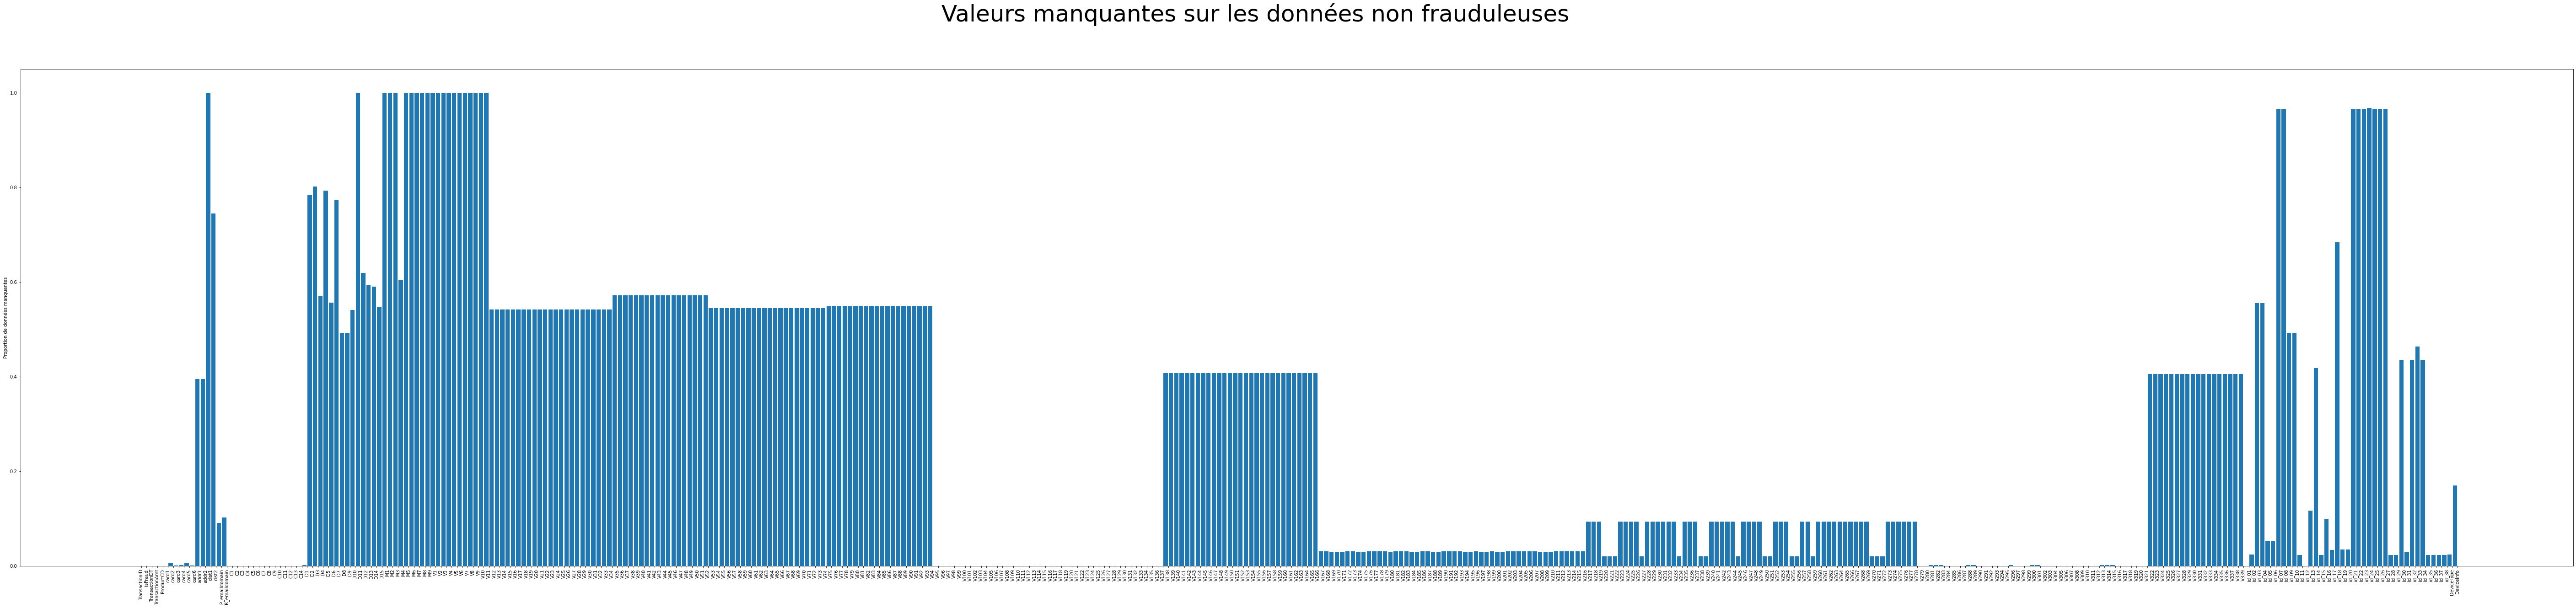

In [85]:
missing_view(train_calibrate[train_calibrate.isFraud == 0])
plt.suptitle("Valeurs manquantes sur les données non frauduleuses", fontsize=50)

De manière générale, on remarque que la représentation est pratiquement la même. On peut dès lors faire une courbe de sensibilité pour voir le nombre de variables par seuil.

**Courbe de sensibilité**

In [86]:
train_column_miss = train_calibrate.isnull().any()
print(f'Nombre de variables avec des données manquantes (apprentissage) : {train_column_miss.sum()} .')

Nombre de variables avec des données manquantes (apprentissage) : 412 .


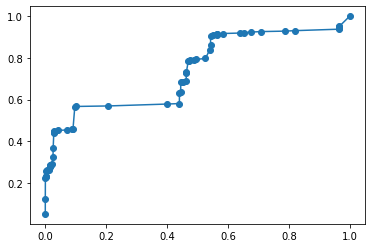

In [87]:
column_miss = train_calibrate.isnull().sum()/train_calibrate.shape[0]
my_series = pd.Series(np.sort(column_miss.values))
sensibility_graph = my_series.value_counts().reset_index().sort_values(by=['index'])
sensibility_graph[0] = np.cumsum(sensibility_graph[0]/sensibility_graph[0].sum())
plt.plot(sensibility_graph['index'], sensibility_graph[0], '-o')

On peut essayer de voir ce qui se passe à partir de 60 % de données manquantes.

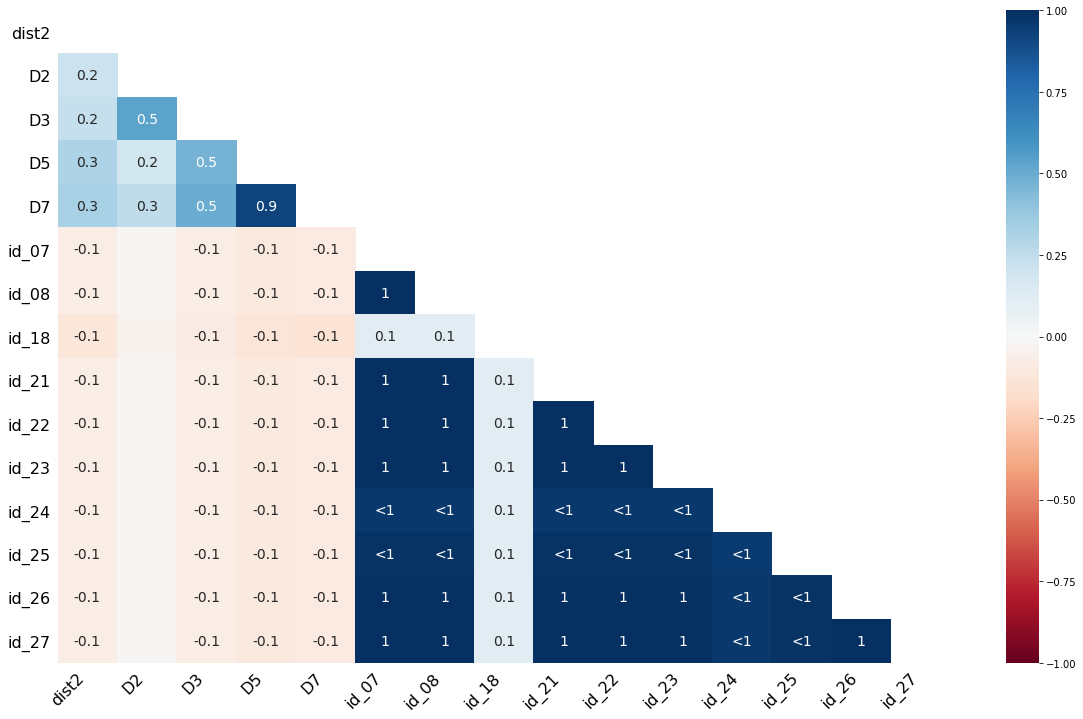

In [88]:
null_counts = train_calibrate.isnull().sum()/len(train_calibrate)
train_data_miss_60 = train_calibrate.filter(items=null_counts[null_counts>=0.6].reset_index()['index'])
msno.heatmap(train_data_miss_60)

On remarque que pour plusieurs des variables, elles prennent conjointement les valeurs manquantes. Couplé au fait que l'apparition des données manquantes est relativement indépendant du caractère frauduleux de la variable, on peut se restreindre aux variables de moins de 60% de valeurs manquantes. De plus, la courbe de sensibilité nous incite à abaisser ce taux à 20% puisqu'il n'y a pas énormément de variables entre 20 et 40%. Une analyse comparative des résultats pourra être ajoutée suivant le seuil choisi.

**Traitement des valeurs manquantes**

In [89]:
###On décide de ne retenir que les variables de moins de 20% de données manquantes et de procéder à une imputation par KNN 
train_work = train_calibrate.filter(items=null_counts[null_counts<0.2].reset_index()['index'])
train_work.shape

(22636, 246)

In [90]:
from sklearn.impute import KNNImputer
train_imputed = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(train_work.select_dtypes(exclude='object'))

In [91]:
train_imputed

array([[2.9870220e+06, 0.0000000e+00, 8.6786000e+04, ..., 1.7780000e+02,
        2.2520000e+02, 2.9380000e+02],
       [2.9871000e+06, 0.0000000e+00, 8.8169000e+04, ..., 1.6600000e+02,
        2.1500000e+02, 5.3300000e+02],
       [2.9871190e+06, 0.0000000e+00, 8.8484000e+04, ..., 1.6600000e+02,
        2.1500000e+02, 2.2200000e+02],
       ...,
       [3.5774780e+06, 0.0000000e+00, 1.5809945e+07, ..., 1.6600000e+02,
        4.1000000e+02, 2.1400000e+02],
       [3.5775260e+06, 1.0000000e+00, 1.5810876e+07, ..., 1.6600000e+02,
        3.5200000e+02, 3.3300000e+02],
       [3.5775290e+06, 0.0000000e+00, 1.5810912e+07, ..., 2.2500000e+02,
        5.6700000e+02, 4.1100000e+02]])

In [92]:
train_imputed = pd.DataFrame(train_imputed)
train_imputed.columns = train_work.select_dtypes(exclude='object').columns
train_imputed = pd.merge(train_imputed,train_work[np.append('TransactionID',train_work.select_dtypes('object').columns.values)],on="TransactionID",how="left")
train_imputed


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,ProductCD,card4,card6,P_emaildomain,R_emaildomain,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,2987022.0,0.0,86786.0,50.000,1724.0,583.0,150.0,226.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-15.0,80008.4,0.8,0.0,100.000000,14.0,177.8,225.2,293.8,H,visa,credit,gmail.com,NaN,NotFound,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987100.0,0.0,88169.0,100.000,16659.0,170.0,150.0,226.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,264818.0,0.0,0.0,100.000000,34.4,166.0,215.0,533.0,H,visa,credit,comcast.net,NaN,NotFound,New,NotFound,New,NotFound,chrome 62.0 for android,T,F,T,T,mobile
2,2987119.0,0.0,88484.0,100.000,2456.0,399.0,150.0,118.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,23923.0,0.0,0.0,100.000000,30.8,166.0,215.0,222.0,H,american express,credit,anonymous.com,anonymous.com,NotFound,Found,Found,Found,Found,chrome 61.0,T,F,T,T,desktop
3,2987121.0,0.0,88517.0,50.000,1804.0,161.0,150.0,117.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,18305.0,2.0,0.0,100.000000,30.8,166.0,215.0,277.0,H,mastercard,debit,gmail.com,NaN,NotFound,Found,Found,Found,Found,chrome 62.0,T,F,T,T,desktop
4,2987125.0,0.0,88556.0,50.000,1804.0,161.0,150.0,117.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,50.000,50.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.0,50.0,50.0,0.0,32876.0,2.0,0.0,100.000000,38.4,166.0,215.0,277.0,H,mastercard,debit,gmail.com,NaN,Found,Found,Found,Found,Found,chrome 62.0,T,F,T,T,desktop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22631,3577469.0,0.0,15809810.0,58.512,14260.0,500.0,185.0,224.0,1.0,12.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,672.888,672.888,87.767998,87.767998,0.0,87.767998,87.767998,87.767998,87.767998,585.119995,585.119995,585.119995,0.0,0.0,0.0,-10.0,62155.0,0.0,0.0,100.000000,52.0,225.0,427.0,595.0,C,mastercard,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 65.0,F,F,T,F,desktop
22632,3577476.0,0.0,15809901.0,58.512,3154.0,408.0,185.0,224.0,2.0,13.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-10.0,81665.0,0.0,0.0,100.000000,52.0,225.0,427.0,595.0,C,mastercard,debit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 65.0,F,F,T,F,desktop
22633,3577478.0,0

**categorical features**

C    12230
R     4528
H     4309
S     1569
Name: ProductCD, dtype: int64


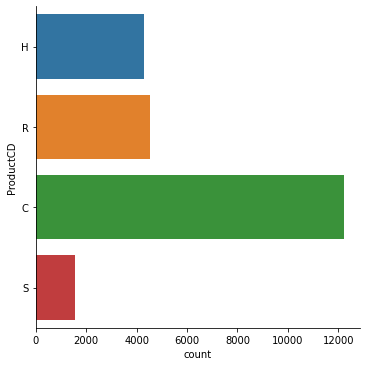

In [93]:
print(train_imputed['ProductCD'].value_counts(dropna=False))
sns.catplot(y='ProductCD',kind='count',data=train_imputed)
  

visa                13925
mastercard           7387
american express      938
discover              352
NaN                    34
Name: card4, dtype: int64


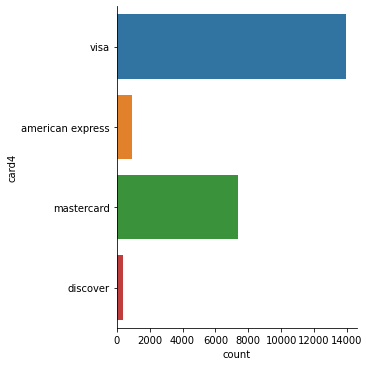

In [94]:
print(train_imputed['card4'].value_counts(dropna=False))
sns.catplot(y='card4',kind='count',data=train_imputed)

credit         12625
debit           9979
NaN               31
charge card        1
Name: card6, dtype: int64


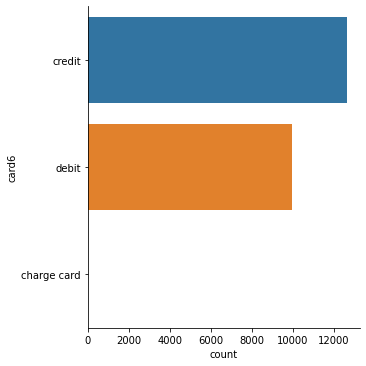

In [95]:
print(train_imputed['card6'].value_counts(dropna=False))
sns.catplot(y='card6',kind='count',data=train_imputed)

gmail.com          10311
hotmail.com         4082
anonymous.com       2073
NaN                 1988
yahoo.com           1524
outlook.com          565
aol.com              431
comcast.net          235
icloud.com           189
yahoo.com.mx         121
msn.com              107
outlook.es            89
live.com.mx           86
live.com              86
verizon.net           81
bellsouth.net         54
cox.net               52
sbcglobal.net         49
mail.com              48
me.com                47
att.net               47
hotmail.es            39
protonmail.com        28
ymail.com             27
charter.net           24
mac.com               23
web.de                23
optonline.net         22
hotmail.fr            20
gmx.de                16
prodigy.net.mx        15
yahoo.fr              15
earthlink.net         13
hotmail.co.uk          9
rocketmail.com         7
yahoo.es               7
suddenlink.net         7
yahoo.de               7
hotmail.de             7
frontiernet.net        6


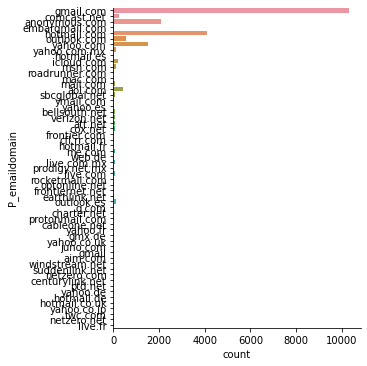

In [96]:
print(train_imputed['P_emaildomain'].value_counts(dropna=False))
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

gmail.com          10694
hotmail.com         4007
anonymous.com       2199
NaN                 1598
yahoo.com           1531
outlook.com          566
aol.com              434
icloud.com           276
comcast.net          173
yahoo.com.mx         121
live.com              93
outlook.es            89
live.com.mx           89
msn.com               72
me.com                65
cox.net               61
verizon.net           60
mail.com              50
sbcglobal.net         44
hotmail.es            39
protonmail.com        39
att.net               34
bellsouth.net         31
web.de                22
ymail.com             21
hotmail.fr            20
mac.com               17
optonline.net         17
charter.net           16
gmx.de                16
yahoo.fr              15
prodigy.net.mx        15
rocketmail.com        10
earthlink.net          9
hotmail.co.uk          9
hotmail.de             7
scranton.edu           7
yahoo.de               7
yahoo.es               7
yahoo.co.uk            6


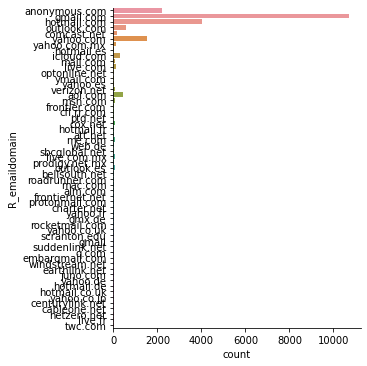

In [97]:
print(train_imputed['R_emaildomain'].value_counts(dropna=False))
sns.catplot(y='R_emaildomain',kind='count',data=train_imputed)

NotFound    19607
Found        3029
Name: id_12, dtype: int64


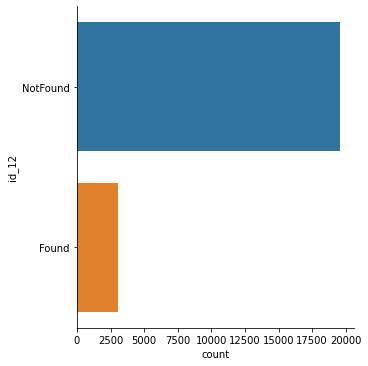

In [98]:
print(train_imputed['id_12'].value_counts(dropna=False))
sns.catplot(y='id_12',kind='count',data=train_imputed)

Found      12268
New         8071
Unknown     1933
NaN          364
Name: id_15, dtype: int64


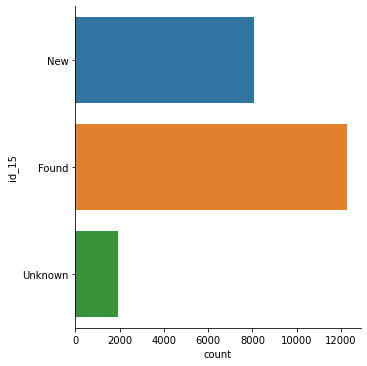

In [99]:
print(train_imputed['id_15'].value_counts(dropna=False))
sns.catplot(y='id_15',kind='count',data=train_imputed)

Found       12140
NotFound     8199
NaN          2297
Name: id_16, dtype: int64


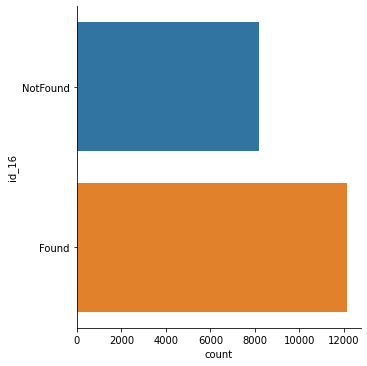

In [100]:
print(train_imputed['id_16'].value_counts(dropna=False))
sns.catplot(y='id_16',kind='count',data=train_imputed)

Found    13680
New       8588
NaN        368
Name: id_28, dtype: int64


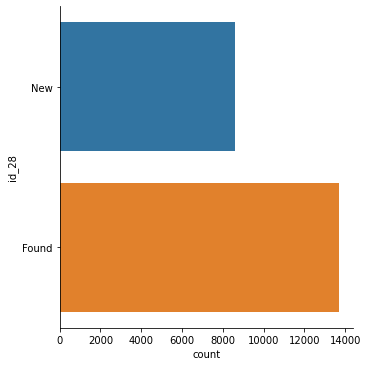

In [101]:
print(train_imputed['id_28'].value_counts(dropna=False))
sns.catplot(y='id_28',kind='count',data=train_imputed)

Found       13563
NotFound     8705
NaN           368
Name: id_29, dtype: int64


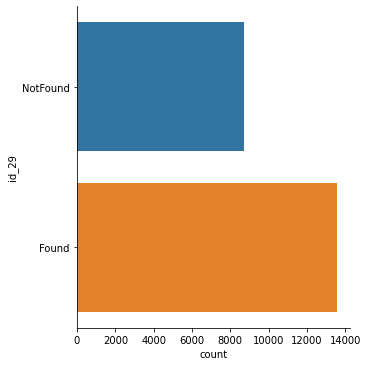

In [102]:
print(train_imputed['id_29'].value_counts(dropna=False))
sns.catplot(y='id_29',kind='count',data=train_imputed)

chrome 63.0                       3326
mobile safari generic             2023
mobile safari 11.0                1920
chrome 65.0                       1190
chrome generic                    1166
chrome 64.0                       1115
chrome 63.0 for android           1057
ie 11.0 for desktop                919
safari generic                     908
chrome 62.0                        889
chrome 64.0 for android            804
chrome 66.0                        745
chrome 65.0 for android            739
NaN                                474
firefox 57.0                       463
chrome 66.0 for android            456
edge 16.0                          446
mobile safari 10.0                 352
chrome 62.0 for android            330
chrome generic for android         204
edge 15.0                          192
firefox                            184
firefox 59.0                       168
samsung browser 6.2                151
firefox 58.0                       142
chrome 61.0 for android  

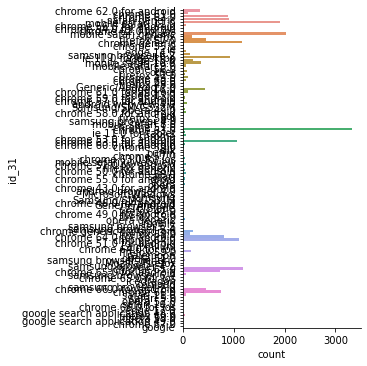

In [103]:
print(train_imputed['id_31'].value_counts(dropna=False))
sns.catplot(y='id_31',kind='count',data=train_imputed)

F      12382
T       9890
NaN      364
Name: id_35, dtype: int64


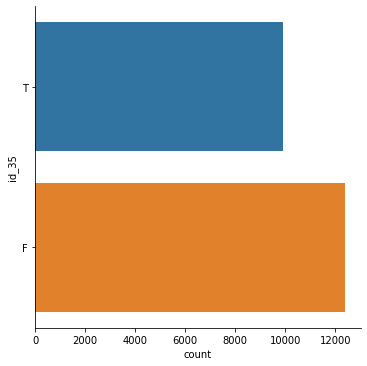

In [104]:
print(train_imputed['id_35'].value_counts(dropna=False))
sns.catplot(y='id_35',kind='count',data=train_imputed)

F      21486
T        786
NaN      364
Name: id_36, dtype: int64


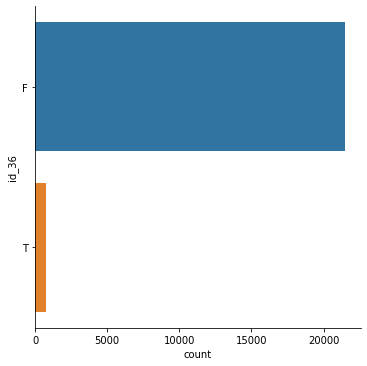

In [105]:
print(train_imputed['id_36'].value_counts(dropna=False))
sns.catplot(y='id_36',kind='count',data=train_imputed)

T      17846
F       4426
NaN      364
Name: id_37, dtype: int64


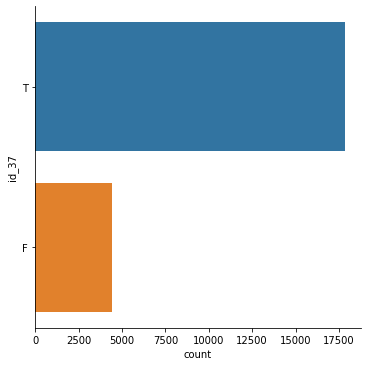

In [106]:
print(train_imputed['id_37'].value_counts(dropna=False))
sns.catplot(y='id_37',kind='count',data=train_imputed)

F      12911
T       9361
NaN      364
Name: id_38, dtype: int64


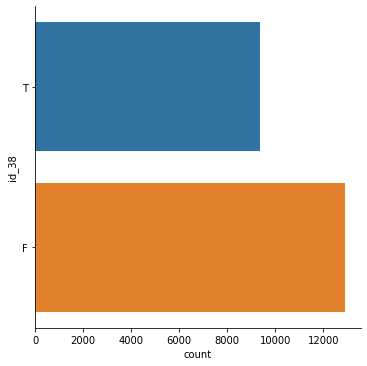

In [107]:
print(train_imputed['id_38'].value_counts(dropna=False))
sns.catplot(y='id_38',kind='count',data=train_imputed)

desktop    12414
mobile      9833
NaN          389
Name: DeviceType, dtype: int64


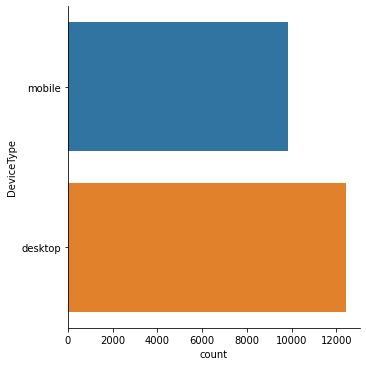

In [108]:
print(train_imputed['DeviceType'].value_counts(dropna=False))
sns.catplot(y='DeviceType',kind='count',data=train_imputed)

**Logistic Regression avec les features numerique**

In [109]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [110]:
train1=train_imputed.drop(['ProductCD','card4','card6','P_emaildomain','R_emaildomain', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37','id_38','DeviceType'],axis=1)
Y_train=train1['isFraud'].astype('int')
X_train=train1.drop('isFraud',axis=1)
scaler=preprocessing.StandardScaler()
X_train_st=scaler.fit_transform(X_train)


In [111]:
logit=LogisticRegression(C=31,random_state=42)
cv_scores = cross_val_score(logit, X_train_st, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.841487883426247

**Feature importance**

Feature: TransactionID Score: 5.64255
Feature: TransactionDT Score: -5.25426
Feature: TransactionAmt Score: 0.43505
Feature: card1 Score: -0.11152
Feature: card2 Score: -0.14426
Feature: card3 Score: 0.28295
Feature: card5 Score: -0.01893
Feature: C1 Score: -2.24277
Feature: C2 Score: 2.17263
Feature: C3 Score: -0.71863
Feature: C4 Score: 1.44522
Feature: C5 Score: 0.00000
Feature: C6 Score: 0.31732
Feature: C7 Score: -5.08830
Feature: C8 Score: 4.45526
Feature: C9 Score: 0.00000
Feature: C10 Score: 3.74063
Feature: C11 Score: 5.43077
Feature: C12 Score: -1.48421
Feature: C13 Score: -2.17924
Feature: C14 Score: -6.72414
Feature: D1 Score: -0.30678
Feature: V95 Score: 0.15275
Feature: V96 Score: -0.25028
Feature: V97 Score: -0.33208
Feature: V98 Score: -0.08234
Feature: V99 Score: 0.13736
Feature: V100 Score: 0.37053
Feature: V101 Score: 0.25211
Feature: V102 Score: -0.09462
Feature: V103 Score: -0.28521
Feature: V104 Score: -0.09535
Feature: V105 Score: -1.12256
Feature: V106 Score: 0.

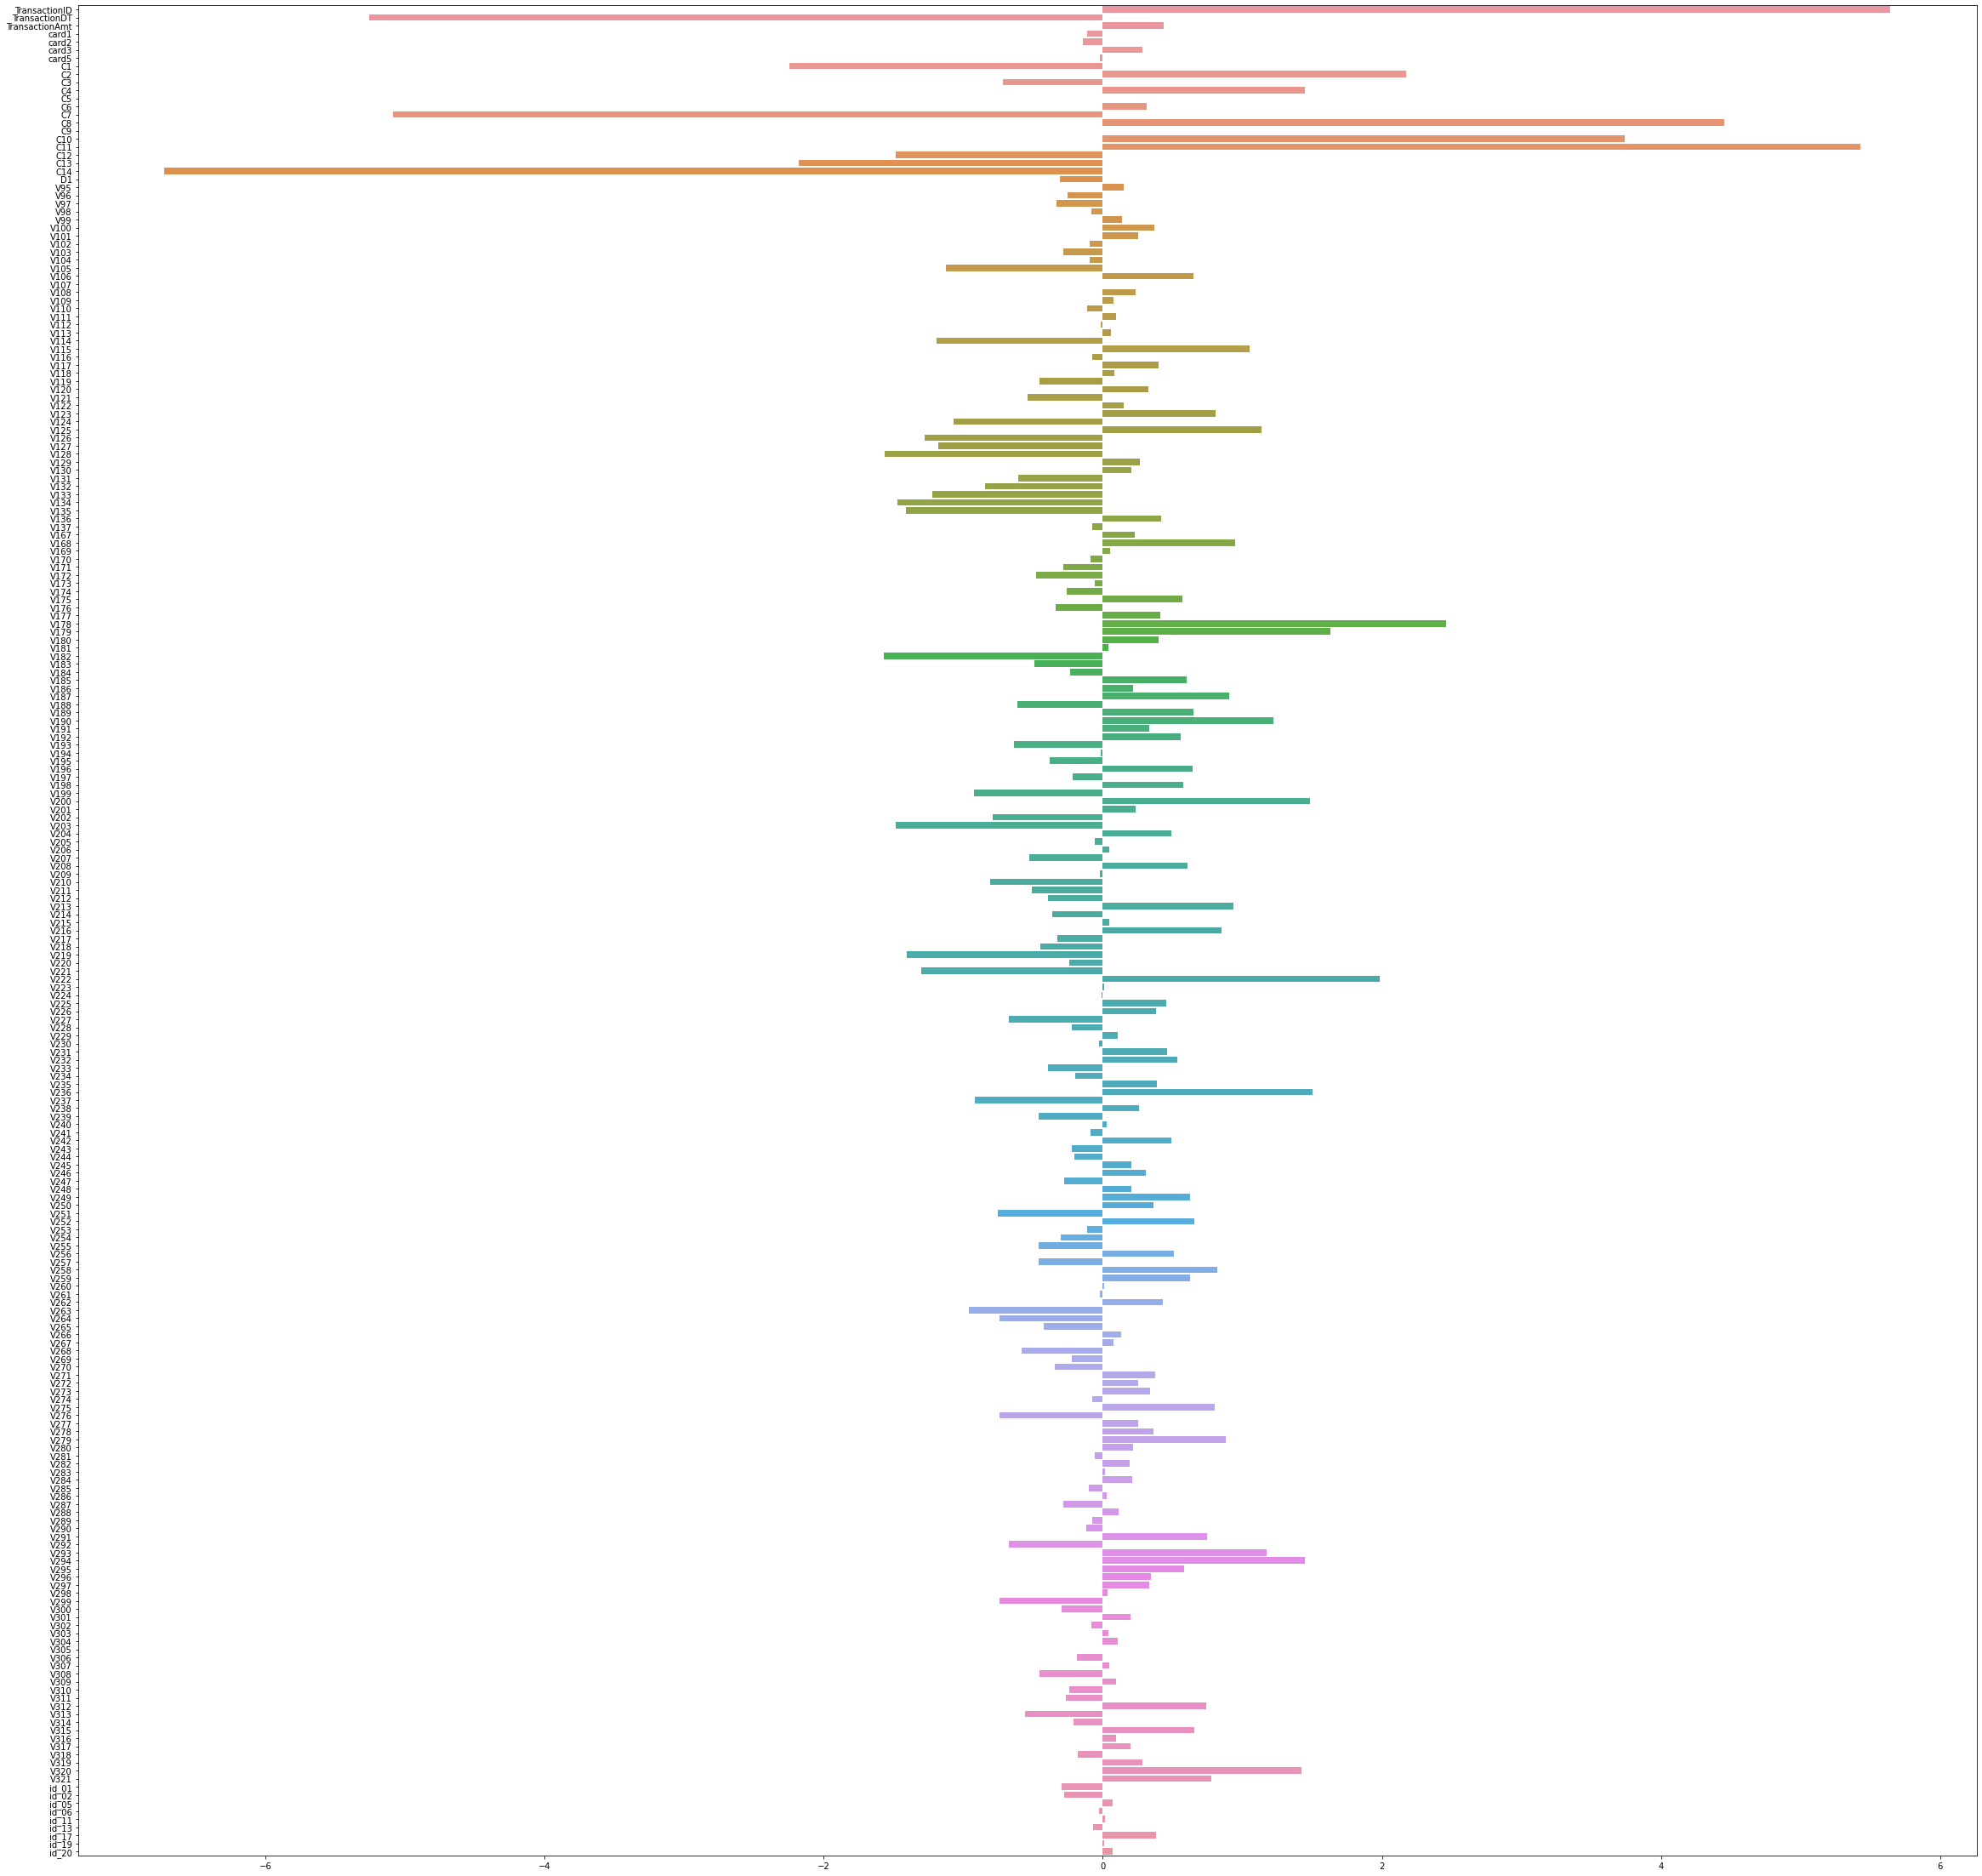

In [112]:
logit.fit(X_train_st,Y_train)
importance = logit.coef_[0]
imp=np.zeros(len(importance))
#summarize feature importance
for i,v in enumerate(importance):
	print('Feature:',list(X_train.columns)[i],'Score: %.5f' % (v))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X_train.columns),ax=ax)

**recrusive feature elimination using cross validation (RFECV)**

In [113]:
from sklearn.feature_selection import RFECV 
rfecv=RFECV(estimator=logit,step=1,scoring="neg_mean_squared_error")
rfecv.fit(X_train_st,Y_train)
rfecv.transform(X_train_st)

array([[-1.57756982, -1.43145919, -0.14237315, ..., -0.07096403,
        -0.08158456, -0.07524623],
       [-1.57712188, -1.43116534, -0.14237315, ..., -0.07096403,
        -0.08158456, -0.07524623],
       [-1.57701276, -1.43109841, -0.14237315, ..., -0.07096403,
        -0.08158456, -0.07524623],
       ...,
       [ 1.81333313,  1.90929663, -0.14237315, ..., -0.07096403,
        -0.08158456, -0.07524623],
       [ 1.81360879,  1.90949444, -0.14237315, ..., -0.07096403,
        -0.08158456, -0.07524623],
       [ 1.81362602,  1.90950209, -0.14237315, ..., -0.07096403,
        -0.08158456, -0.07524623]])

In [114]:
rfecv.n_features_#Number of best features

35

In [115]:
rfecv.ranking_

array([  1,   1,  35, 137, 119,  32, 163,   1,  26,   1,   1, 195, 120,
         1,   1, 193,   1,   1,   1,   1,   1,  46,  33,  88, 125, 169,
       160, 126,  92, 129,   1, 141,   1,  63, 192,  76, 110, 109, 138,
       175, 161,  13,  14, 164,  51, 159,  52, 130,  81,  82,   1,  80,
        77,  47,   6,  18, 103,  95, 102,   1,   1,   1,  29, 123, 173,
       116,  45, 180, 182, 111, 107, 185,  25,  24,   1, 112,   1,  30,
        21,  17,  11,  65,  75,  66, 149,   1,  22,  15,   1,  99, 104,
       106, 178,  85,  41, 133,  86,   8,   1, 115,  23,   1,   1, 168,
       177,  12,  19, 171,  20,  37, 105,   1, 108, 188,  60, 139,  53,
        36,  87,   1,   1, 181, 179,  58,  83,  69, 131, 166, 170, 118,
         1,  16, 114, 124,   1,   3,  79,  78, 165, 147,  44,  67, 146,
       128, 132,  98,  62,  94,  84,  70,   1, 176,  93,   5,  68,  54,
        48,   2, 191, 127,  31,   9,   1,  74, 121, 189,  57, 101,  56,
        55,  91,   7,  97,  73, 100,  64,   4,   1,   1, 172, 11

In [116]:
rfecv.support_#which features to keep 

array([ True,  True, False, False, False, False, False,  True, False,
        True,  True, False, False,  True,  True, False,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False,

In [117]:
pp=[]
for i in range(len(rfecv.support_)):
  if rfecv.support_[i]==False:
    pp.append(list(X_train.columns)[i])
X_train1=X_train.drop(pp,axis=1)
scaler=preprocessing.StandardScaler()
X_train_st1=scaler.fit_transform(X_train1)
logit=LogisticRegression(C=1,random_state=42)
cv_scores = cross_val_score(logit, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score reste le meme


0.8500779692309772

**Removing irrelevant features**

In [118]:
#il faut q'on fixe un thresh hold q
l1=[]#liste des features sans imporatnace
for i in range(len(imp)):
  if imp[i]==0:
    l1.append(list(X_train.columns)[i])
X_train1=X_train.drop(l1,axis=1)
scaler=preprocessing.StandardScaler()
X_train_st1=scaler.fit_transform(X_train1)
logit=LogisticRegression(C=31,random_state=42)
cv_scores = cross_val_score(logit, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score reste le meme

0.8414881956651881

**Logistic Regression avec toutes les features(still unclear)**

In [119]:
sites = ['ProductCD','card4','card6','P_emaildomain','R_emaildomain', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37','id_38','DeviceType']
train1=train_imputed.drop(sites,axis=1)
Y_train=train1['isFraud'].astype('int')
X_train=train1.drop('isFraud',axis=1)
X1_train=pd.merge(X_train,pd.get_dummies(train_imputed[sites]),right_index=True,left_index=True)
scaler=preprocessing.StandardScaler()
X_train_st1=scaler.fit_transform(X1_train)

In [120]:
logit=LogisticRegression(C=1,random_state=42)
cv_scores = cross_val_score(logit, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.8367009442032473

**Feature importance**

Feature: TransactionID Score: 1.97821
Feature: TransactionDT Score: -1.57346
Feature: TransactionAmt Score: 0.63130
Feature: card1 Score: -0.08632
Feature: card2 Score: -0.16680
Feature: card3 Score: 0.27081
Feature: card5 Score: -0.00089
Feature: C1 Score: -1.88785
Feature: C2 Score: 2.25161
Feature: C3 Score: -0.95461
Feature: C4 Score: 0.65853
Feature: C5 Score: 0.00000
Feature: C6 Score: 0.55959
Feature: C7 Score: -3.03592
Feature: C8 Score: 2.44512
Feature: C9 Score: 0.00000
Feature: C10 Score: 1.90760
Feature: C11 Score: 3.39758
Feature: C12 Score: -0.52551
Feature: C13 Score: -1.75198
Feature: C14 Score: -4.07862
Feature: D1 Score: -0.28672
Feature: V95 Score: 0.04381
Feature: V96 Score: 0.01879
Feature: V97 Score: -0.03697
Feature: V98 Score: -0.04467
Feature: V99 Score: 0.53131
Feature: V100 Score: 0.12384
Feature: V101 Score: 0.08776
Feature: V102 Score: 0.08009
Feature: V103 Score: -0.00828
Feature: V104 Score: -0.34193
Feature: V105 Score: -0.53570
Feature: V106 Score: 0.24

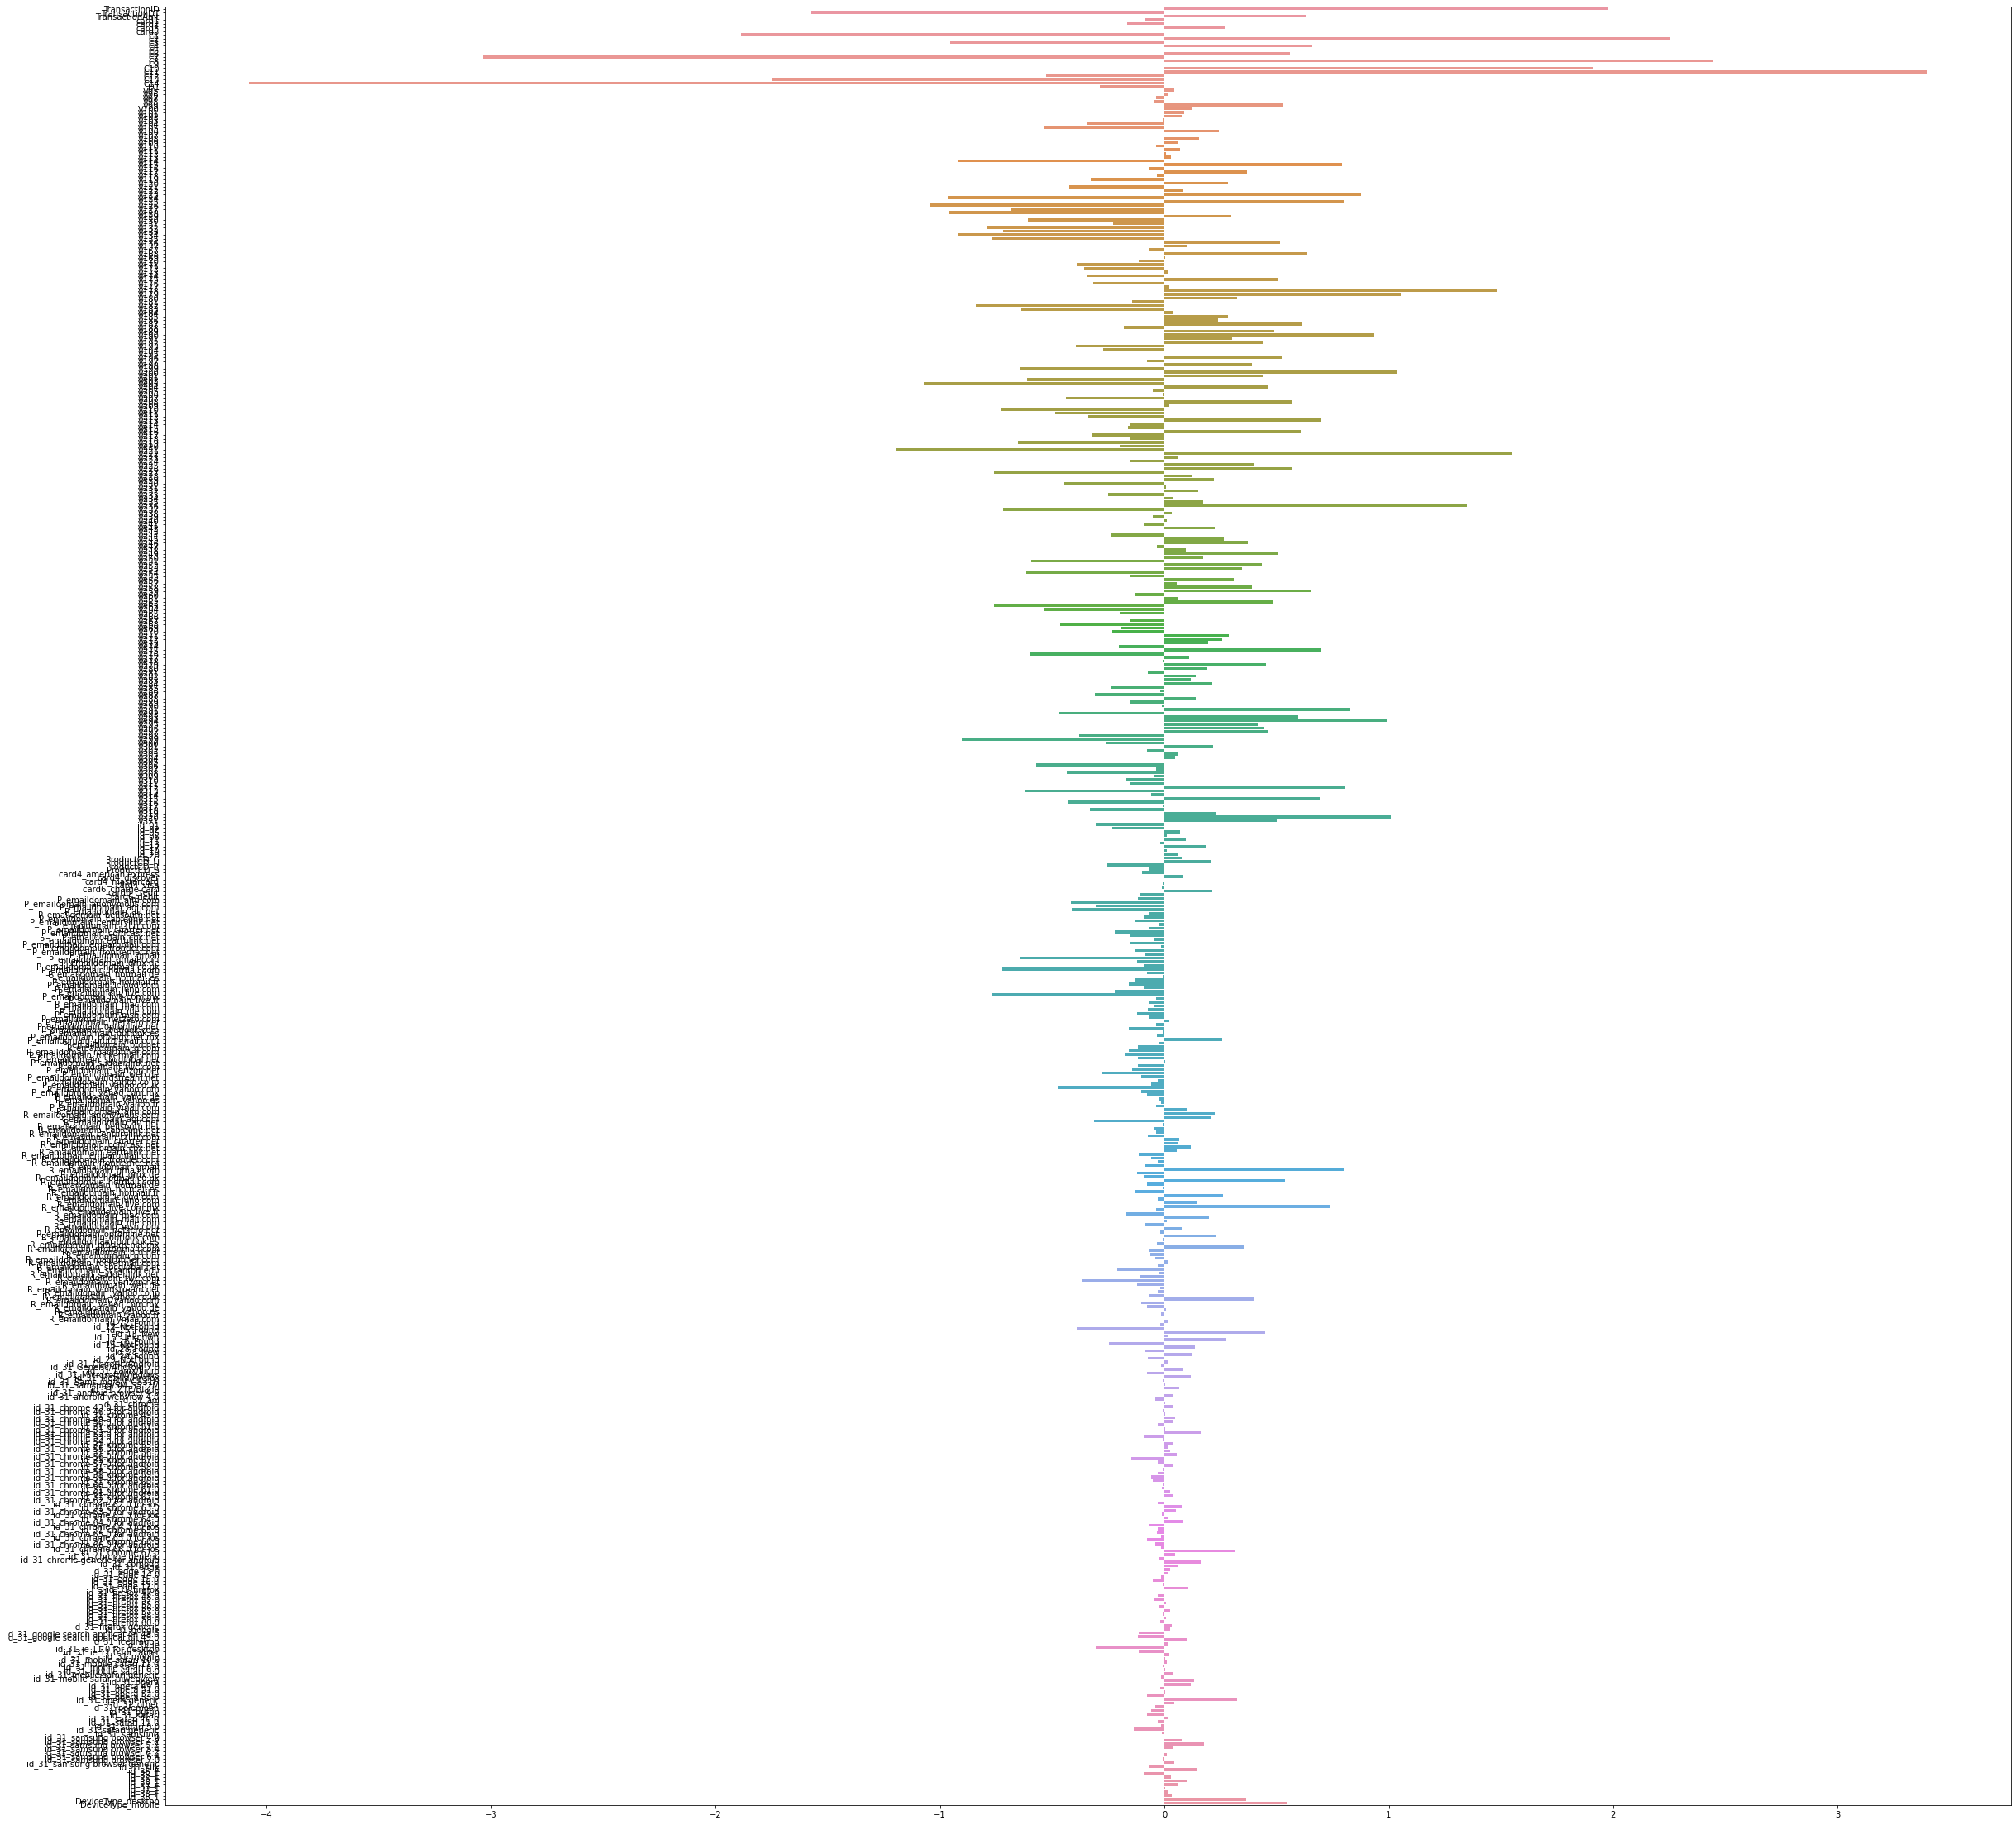

In [121]:
logit.fit(X_train_st1,Y_train)
importance = logit.coef_[0]
imp=np.zeros(len(importance))
#summarize feature importance
for i,v in enumerate(importance):
	print('Feature:',list(X1_train.columns)[i],'Score: %.5f' % (v))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X1_train.columns),ax=ax)